In [1]:
# Local Imports
import preprocess
# Primary Data Libraries
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
# time series algorithm
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
# reproducibility
np.random.seed(34)

# Jupyter magic
%reload_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

In [37]:
def run_prophet(train):
    '''Fit and return a fbprophet model expecting daily series data and predicting 1 month in the future '''
    assert series.shape[1] == 2 # Make sure it's the right shape for fbprophet
    assert pd.core.dtypes.common.is_datetime64_any_dtype(series[series.columns[0]]) # make sure first column is datetime
    series.columns = ['ds','y'] # assign proper column names that fbprophet requires
    m = Prophet(weekly_seasonality=True, daily_seasonality=False, n_changepoints=2)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=1)
    m.fit(train)
    future = m.make_future_dataframe(periods=30, freq='D')
    forecast = m.predict(future)
    return m, forecast

In [3]:
# Load Data
orders = pd.read_csv('orders.csv')
items = pd.read_csv('items.csv')
data = preprocess.process_data(orders, items)
del items; del orders

In [11]:
df = preprocess.select_series(data)
df.columns = ['ds','y']
df.ds = pd.to_datetime(df['ds'])
df.head()

,ds,y
0,2019-06-01,27908.367718
1,2019-06-02,3548.233795
2,2019-06-03,7459.449875
3,2019-06-04,80648.471119
4,2019-06-05,86861.314487


In [12]:
# df = df.groupby(pd.Grouper(freq='M', key = 'ds')).sum()
# df.reset_index(inplace=True)

In [13]:
df.sort_values('ds',inplace=True)
df.tail()

,ds,y
477,2020-09-20,69345.517422
478,2020-09-21,75297.247771
479,2020-09-22,63457.730980
480,2020-09-23,63926.816871
481,2020-09-24,47282.482778


In [14]:
train  = df[:-24]
test = df[-24:]

In [15]:
m = Prophet(weekly_seasonality=True, daily_seasonality=False, n_changepoints=2)
m.add_seasonality(name='monthly', period=30.5, fourier_order=1)
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


&lt;fbprophet.forecaster.Prophet at 0x7fb9e76c4ed0&gt;

In [16]:
future = m.make_future_dataframe(periods=24, freq='D')
forecast = m.predict(future)
forecast.columns

Index([&#39;ds&#39;, &#39;trend&#39;, &#39;yhat_lower&#39;, &#39;yhat_upper&#39;, &#39;trend_lower&#39;, &#39;trend_upper&#39;,
       &#39;additive_terms&#39;, &#39;additive_terms_lower&#39;, &#39;additive_terms_upper&#39;,
       &#39;monthly&#39;, &#39;monthly_lower&#39;, &#39;monthly_upper&#39;, &#39;weekly&#39;, &#39;weekly_lower&#39;,
       &#39;weekly_upper&#39;, &#39;multiplicative_terms&#39;, &#39;multiplicative_terms_lower&#39;,
       &#39;multiplicative_terms_upper&#39;, &#39;yhat&#39;],
      dtype=&#39;object&#39;)

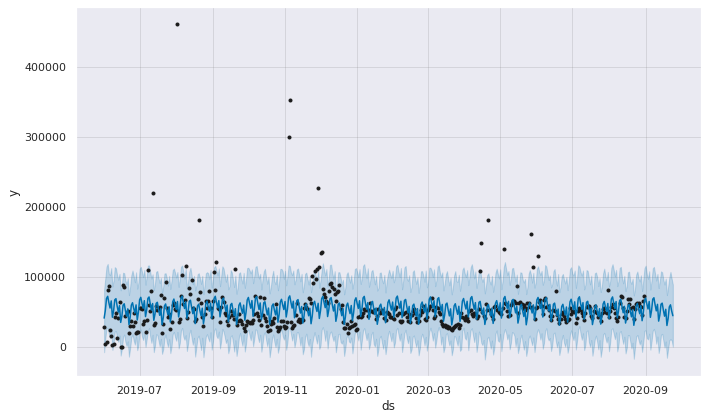

In [17]:
figure = m.plot(forecast)

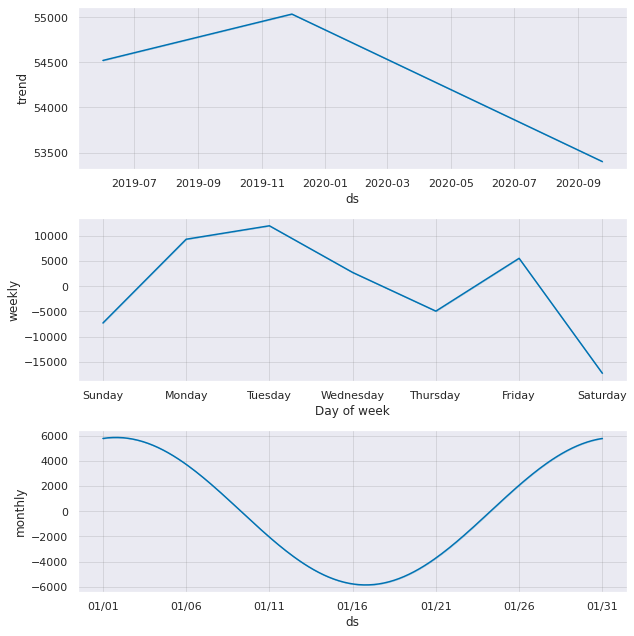

In [18]:
fig_decompose = m.plot_components(forecast)

In [19]:
predictions = forecast.yhat[-24:]
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test.y, predictions))
rmse

33198.85717582892

In [22]:
cv_results = cross_validation(m, initial='180 days', period='30 days', horizon='30 days')

INFO:fbprophet:Making 9 forecasts with cutoffs between 2019-12-05 00:00:00 and 2020-08-01 00:00:00


In [25]:
mape_baseline = mean_absolute_percentage_error(cv_results.y, cv_results.yhat)

In [26]:
mape_baseline

36.212639792822536

# Baseline To Compare Model To

# Cross Validation

In [ ]:

df_cv = cross_validation(m, initial='730 days', period='30 days', horizon = '30 days')

In [ ]:
fig, ax = plt.subplots(10,1, figsize = (14, 20))
ax = ax.ravel()
j = 0
for i in [0.01, 0.05, 0.10, 0.15, 0.20]:
    RUT2 = RUT.reset_index()
    RUT2 = RUT2.rename(columns = {'Date' : 'ds', 'Adj Close' : 'y'} )
    m = Prophet(changepoint_prior_scale=i)
    #fit the prophet model on the data
    m.fit(RUT2)
    # make a dataframe of the next two years 
    future = m.make_future_dataframe(periods=365)
    #predict on this future dataframe
    forecast = m.predict(future)
    # plot the forecast 
    fig = m.plot(forecast, ax = ax[j])
    ax[j].set_title('changepoint prior = ' + str(i))
    j += 1
    df_cv = cross_validation(m, initial='365 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv)
    fig = plot_cross_validation_metric(df_cv, metric='mape', ax = ax[j])
    ax[j].set_title(str(str(i) + ' Change Point Prior Mean Absolute Percentage Error'))
    ax[j].set_ylim(0,0.5)
    j += 1

In [ ]:
{'changepoint_prior_scale': 0.6,
'n_changepoints': 6,
'seasonality_mode': 'additive',
'seasonality_prior_scale': 0.0001,
'growth': 'logistic',
'changepoint_range': 0.8,
'holidays_prior_scale': 0,
'mcmc_samples': 0,
'weekly_seasonality': False,
'daily_seasonality': False}

In [8]:
pd.to_timedelta(12*30,unit="D")

Timedelta(&#39;360 days 00:00:00&#39;)

# Different Sites

In [4]:
sites = data.site.unique()
sites = [site for site in sites if isinstance(site,str)]
country_codes = {country for country in [site[-2:] for site in sites]}
grouped_sites = []
for code in country_codes:
    grouped_sites.append([site for site in sites if site[-2:] == code])

In [106]:
errors = []
for i, sites_list in enumerate(grouped_sites):
    series = preprocess.select_series(data, site=sites_list)
    series.columns = ['ds','y']
    train = series[:-30]
    test = series[-30:]
    m, forecast = run_prophet(train)
    forecast['cutoff'] = train.ds.iloc[train.shape[0]-1]
    forecast['y'] = series.y
    df_p = performance_metrics(forecast)
    plt.plot(forecast.yhat[-30:].values, label = 'predicted')
    plt.plot(test.iloc[:,1].values, label = 'actual')
    plt.legend()
    plt.savefig(f'./predicted_actual/temp{i}')
    plt.show()
    mape = mean_absolute_percentage_error(test.iloc[:,1].values,forecast.yhat[-30:].values)
    errors.append(mape)
    print(f'Mean Absolute Percent Error: {mape}')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Mean Absolute Percent Error: 29.170121609219613
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Mean Absolute Percent Error: 39.548879979097656
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Mean Absolute Percent Error: 35.011028295394176
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Mean Absolute Percent Error: 27.389338200466867
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Mean Absolute Percent Error: inf
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Mean Absolute Percent Error: 44.51002921715684


In [111]:
np.mean(errors)

34.29862148478335

In [42]:
m, forecast = run_prophet(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


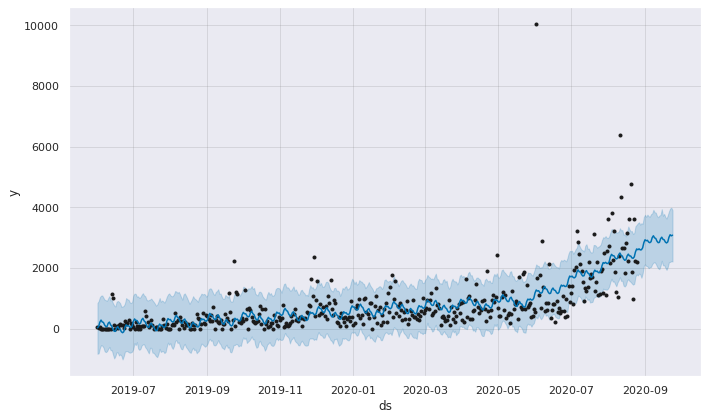

In [43]:
fig = m.plot(forecast)


In [61]:
forecast['cutoff'] = train.ds.iloc[train.shape[0]-1]
forecast['y'] = series.y

In [62]:
df_p = performance_metrics(forecast)

INFO:fbprophet:Skipping MAPE because y close to 0


In [94]:
def compare_to_baseline(forecast, forecast_metrics, series, cutoffrow):
    ''' compare a trained fbprophet model to the baseline persistence model'''
    df_p = forecast_metrics
    train = series[:cutoffrow]
    forecast_persist = forecast
    forecast_persist['cutoff'] = train.ds.iloc[train.shape[0]-1]
    forecast_persist['y'] = series.y
    forecast_persist['yhat'] = train.y.iloc[train.shape[0]-1]

    df_persist = performance_metrics(forecast_persist)

    df_p.index = df_p['horizon']
    df_persist.index = df_persist['horizon']
    df_error_compare_persist = df_persist - df_p
    df_error_compare_persist = df_error_compare_persist.drop(columns=['horizon', 'coverage'])
    return df_error_compare_persist

df_error_compare_persist = compare_to_baseline(forecast, df_p, series, -30)
# df_error_compare_persist.loc['0 days':] 
# If errors are mostly positive, then df_persist error is greater than the compared model and so the actual model performed better than a persistence model

INFO:fbprophet:Skipping MAPE because y close to 0


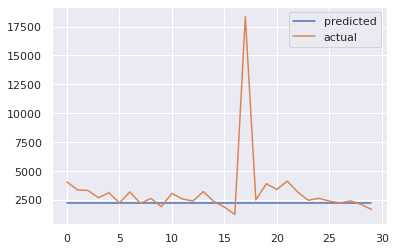

In [93]:
plt.plot(forecast.yhat[-30:].values, label = 'predicted')
plt.plot(test.y.values, label = 'actual')
plt.legend()
plt.savefig('./predicted_actual/temp')
plt.show()